## Assignment 1

We first import the necessary libraries:

In [173]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
from numba import njit, float64
from numba.experimental import jitclass
from scipy.optimize import fsolve, minimize_scalar, bisect
import numpy as np
from interpolation import interp

In [174]:
def maximize(g, a, b, args):
    """
    Maximize the function g over the interval [a, b].

    We use the fact that the maximizer of g on any interval is
    also the minimizer of -g.  The tuple args collects any extra
    arguments to g.

    Returns the maximal value and the maximizer.
    """

    objective = lambda x: -g(x, *args)
    result = minimize_scalar(objective, bounds=(a, b), method='bounded')
    maximizer, maximum = result.x, -result.fun
    return maximizer, maximum

Now, we define an instance of the optimal growth model. 

In [175]:
class ngm():

    def __init__(self, σ=1, β=0.984, δ=0.025, α=1/3, k0 = 1):
        'Parameters:'
        self.σ, self.β, self.δ, self.α, self.k0 = σ, β, δ, α, k0
        
        'Endogenous outcomes and endogenous grid:'
        self.steadystate = self.find_ss()
        self.k0 = 0.75*self.find_ss()
        self.grid = self.create_grid(self.steadystate)
        self.v_initial = self.v_initial()

    def u(self, c):
        '''
        Utility function
        '''
        σ = self.σ

        return c ** (1 - σ) / (1 - σ) if σ!= 1 else np.log(c)

    def u_prime(self, c):
        'Derivative of utility'
        σ = self.σ

        return c ** (-σ)

    def u_prime_inv(self, c):
        'Inverse of derivative of utility'
        σ = self.σ

        return c ** (-1 / σ)

    def f(self, k):
        'Production function'
        α = self.α

        return k ** α

    def f_prime(self, k):
        'Derivative of production function'
        α = self.α

        return α * k ** (α - 1)

    def f_prime_inv(self, k):
        'Inverse of derivative of production function'
        α = self.α 

        return (k / α) ** (1 / (α - 1))
    
    def ss(self, k):
        'Define the steady-state equation'
        β, δ = self.β, self.δ
        f_prime = self.f_prime
        
        return β*(f_prime(k) + (1-δ)) - 1
        
    def find_ss(self):
        'Solve the steady-state equation'
        ss = self.ss
        steady_state = fsolve(ss, 1e-10)
        return steady_state[0]
    
    def create_grid(self, reference):
        'Create a grid as prescribed in the assignment'
        grid = np.linspace(0.5 * reference, 1.5 * reference, 1000)
        return grid
    
    def v_initial(self):
        'Create initialization for value function'
        grid = self.grid
        v_initial = np.empty_like(grid)
        return v_initial      
    
    def state_action_value(self, k_new, k, v_array):
        
        v = lambda x: interp(self.grid, v_array, x) 
        
        u, f = self.u, self.f
        β, δ = self.β, self.δ
        return u(f(k) + (1-δ)*k - k_new) + β*v(k_new) #k_new is the thing we solve for
        # This is the right hand side of the bellman

Next, we implement part two of the code, iteration of the bellman equation

In [176]:
def T(v, ngm):
    """
    The Bellman operator.  Updates the guess of the value function.
    * v is an array representing a guess of the value function

    """
    v_new = np.empty_like(v)
    
    for i, k in enumerate(ngm.grid):
        # Maximize RHS of Bellman equation at state x
        v_new[i] = maximize(ngm.state_action_value, (1-ngm.δ)*k, ngm.f(k) + (1-ngm.δ)*k, (k, v))[1]

    return v_new

In [177]:
T(ngm().v_initial, ngm())

array([0.81357158, 0.81423824, 0.81490358, 0.81556759, 0.81623028,
       0.81689165, 0.81755172, 0.81821048, 0.81886794, 0.81952411,
       0.82017899, 0.82083258, 0.8214849 , 0.82213594, 0.82278571,
       0.82343422, 0.82408147, 0.82472746, 0.8253722 , 0.8260157 ,
       0.82665796, 0.82729899, 0.82793878, 0.82857735, 0.8292147 ,
       0.82985083, 0.83048575, 0.83111947, 0.83175198, 0.83238329,
       0.83301341, 0.83364234, 0.83427008, 0.83489665, 0.83552204,
       0.83614626, 0.83676931, 0.8373912 , 0.83801193, 0.83863151,
       0.83924994, 0.83986722, 0.84048337, 0.84109837, 0.84171224,
       0.84232499, 0.84293661, 0.84354711, 0.84415649, 0.84476476,
       0.84537193, 0.84597799, 0.84658295, 0.84718681, 0.84778958,
       0.84839127, 0.84899187, 0.84959139, 0.85018983, 0.8507872 ,
       0.85138351, 0.85197874, 0.85257292, 0.85316604, 0.8537581 ,
       0.85434912, 0.85493909, 0.85552802, 0.85611591, 0.85670276,
       0.85728858, 0.85787338, 0.85845715, 0.8590399 , 0.85962

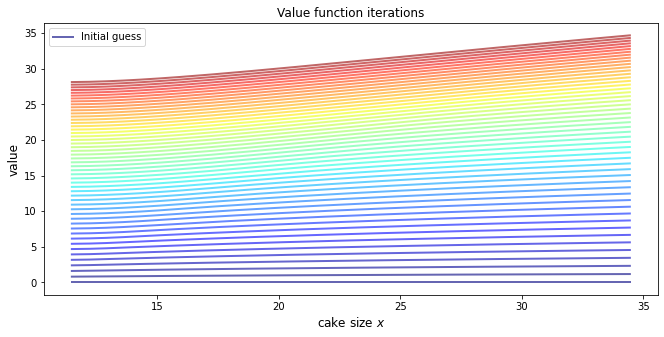

In [178]:
x_grid = ngm().grid
v = ngm().v_initial       # Initial guess
n = 50                 # Number of iterations

fig, ax = plt.subplots()

ax.plot(x_grid, v, color=plt.cm.jet(0),
        lw=2, alpha=0.6, label='Initial guess')

for i in range(n):
    v = T(v, ngm())  # Apply the Bellman operator
    ax.plot(x_grid, v, color=plt.cm.jet(i / n), lw=2, alpha=0.6)

ax.legend()
ax.set_ylabel('value', fontsize=12)
ax.set_xlabel('cake size $x$', fontsize=12)
ax.set_title('Value function iterations')

plt.show()